## Import stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

## Set up the prior

In [2]:
lower = np.array([0.0])
upper = np.array([1.0])
prior = priors.Uniform(lower, upper)

## Load in the compressed data vector, sims, Fisher matrix, fiducial params
`compressed_data` is an array of length `n_summaries`<br>
`sim_params` is an array with shape `(n_simulations, n_parameters)`<br>
`sim_compressed_data` is an array with shape `(n_simulations, n_summaries)`

In [3]:
# we define a few hyper parameters here
np.random.seed(13)
n = 1000 # total number of datapoints
n_class = 1 # number of different cosmologies for the training
q_prior = np.linspace(0.18, 0.22, n) #np.concatenate((np.linspace(0.0, 1.0, 0), np.linspace(0.76, 0.80, 10*n))) #np.random.uniform(0, 1, n)
q_fid = np.random.uniform(0, 1, 1)

In [4]:
q_fid 

array([0.77770241])

In [5]:
# we need to create n observations at the fiducial point
# then, we calculate their mean and covariance matrix for now

n_vec = 50 # number of components of the data
d_vec = []
for _ in range(n):
    d_vec.append([np.random.lognormal(q_fid, (i+1)/(n_vec*100.0), 1) for i in range(n_vec)])

d_vec = np.reshape(np.asarray(d_vec), [-1, n_vec])
mu = np.mean(d_vec, axis=0)
cov = np.cov(d_vec, rowvar=False)
Cinv = np.linalg.inv(cov)

# then we also measure the derivative, which means
# we define a small step h, and calculate the difference in the mean
# with respect to that step

h = 0.01
q_fid_p = q_fid + h
d_vec_p = []
for _ in range(n):
    d_vec_p.append([np.random.lognormal(q_fid_p, (i+1)/(n_vec*100.0), 1) for i in range(n_vec)])

d_vec_p = np.reshape(np.asarray(d_vec_p), [-1, n_vec])
mu_p = np.mean(d_vec_p, axis=0)
dmudt = mu_p - mu
dmudt = np.reshape(dmudt, [1, -1])

In [6]:
# now we define the score compression
Compressor = score.Gaussian(n_vec, q_fid, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None

In [7]:
compressor(d_vec[0])

array([0.78300936])

In [8]:
dmudt

array([[0.02188519, 0.02192047, 0.02183095, 0.02193502, 0.02173755,
        0.02177888, 0.02197335, 0.02191083, 0.02209275, 0.02225282,
        0.02203168, 0.02179752, 0.02188523, 0.02226725, 0.02165774,
        0.02171779, 0.02091915, 0.0216416 , 0.02198328, 0.02157387,
        0.02096984, 0.02259563, 0.02224457, 0.02172749, 0.02122726,
        0.022553  , 0.02119675, 0.02208186, 0.02241657, 0.02149917,
        0.02214244, 0.02166121, 0.02294053, 0.02165532, 0.02231879,
        0.02116054, 0.0221456 , 0.02344007, 0.02334164, 0.02133381,
        0.02162877, 0.02237447, 0.02265907, 0.02123945, 0.02336373,
        0.02301132, 0.02165447, 0.02222385, 0.02409043, 0.02125839]])

In [9]:
Cinv

array([[ 5.63648325e+06, -9.86034304e+04, -5.23906707e+04, ...,
        -3.39342860e+03,  7.26165681e+02, -6.45092361e+03],
       [-9.86034304e+04,  1.41045183e+06, -1.19183541e+04, ...,
         2.43700280e+03,  1.54691765e+03, -9.30713469e+02],
       [-5.23906707e+04, -1.19183541e+04,  6.04335302e+05, ...,
        -3.13341633e+02, -9.07470388e+02,  1.76633540e+03],
       ...,
       [-3.39342860e+03,  2.43700280e+03, -3.13341633e+02, ...,
         2.54491771e+03,  1.23845798e+02, -3.79938136e+01],
       [ 7.26165681e+02,  1.54691765e+03, -9.07470388e+02, ...,
         1.23845798e+02,  2.31155458e+03, -6.76155030e+01],
       [-6.45092361e+03, -9.30713469e+02,  1.76633540e+03, ...,
        -3.79938136e+01, -6.76155030e+01,  2.23449541e+03]])

In [10]:
n_vec = 50 # number of components of the data
# we create the observed data point, for now at the fiducial value of q
q_fid = 0.2
d_vec_obs = []
for _ in range(1):
    d_vec_obs.append([np.random.lognormal(q_fid, (i+1)/(n_vec*100.0), 1) for i in range(n_vec)])

# we also create the data for the training
d_vec_q = []
for q in q_prior:
    d_vec_q.append([np.random.lognormal(q, (i+1)/(n_vec*100.0), 1) for i in range(n_vec)])

d_vec_obs = np.reshape(np.asarray(d_vec_obs), [-1, n_vec])
d_vec_obs_keep = np.copy(d_vec_obs)
d_vec_q = np.reshape(np.asarray(d_vec_q), [-1, n_vec])

print(d_vec_obs.shape, d_vec_q.shape)

(1, 50) (1000, 50)


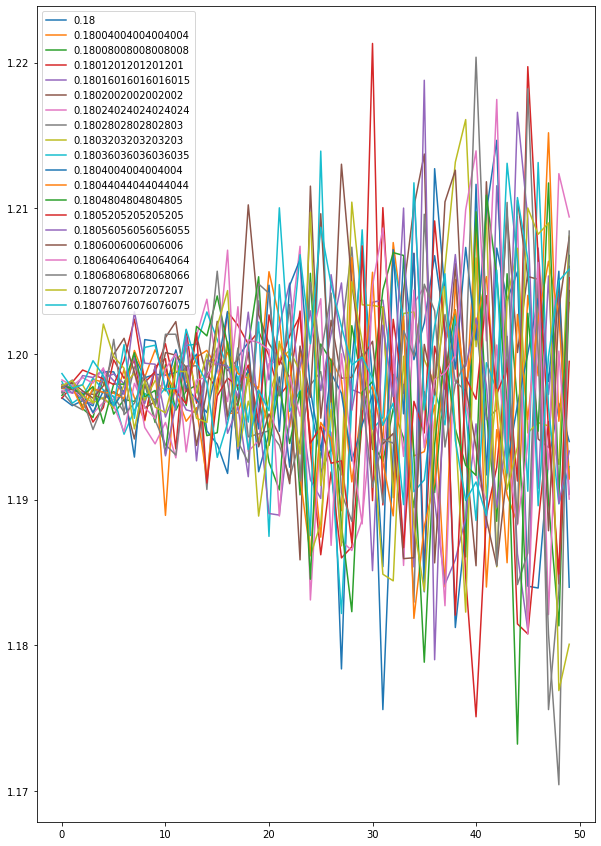

In [11]:
# we plot a few things to make sure everything is good
plt.figure(figsize=(10, 15))
for index in range(20):
    plt.plot(np.arange(n_vec), d_vec_q[index], label=q_prior[index])

plt.legend()


## Compression

In [12]:
d_vec_q.shape

(1000, 50)

In [13]:
# we need to retrieve all the needed summaries here, so:
# 1) the summary of the observation
# 2) the summaries of the noise realisations
summaries_noise = []
for index in range(n):
    summaries_noise.append(compressor(d_vec_q[index]))
summaries_noise = np.asarray(summaries_noise)
summary_obs = compressor(d_vec_obs[0])
summary_obs = np.reshape(summary_obs, [1, 1])

In [14]:
summaries_noise.shape

(1000, 1)

In [15]:
summary_obs.shape

(1, 1)

In [16]:
compressed_data = summary_obs[0]

sim_params = np.reshape(q_prior, [-1, 1])

sim_compressed_data = summaries_noise

#Finv = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/Finv.dat')

theta_fiducial = np.array(q_fid)

## Create ensemble of NDEs

In [17]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=1, n_data=1, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]

## Create DELFI object

In [18]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,  
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['q'], 
                            results_dir = "./attempt_results")

## Load simulations into DELFI object

In [19]:
DelfiEnsemble.load_simulations(sim_compressed_data, sim_params)

## Fisher pre-training to initialize networks

In [20]:
#DelfiEnsemble.fisher_pretraining(n_batch=5000, batch_size=100)

# Train the networks

In [21]:
DelfiEnsemble.train_ndes()

# Sample the learned posterior

In [22]:
#posterior_samples = DelfiEnsemble.emcee_sample()

# Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [23]:
#DelfiEnsemble.triangle_plot(samples=[posterior_samples])

In [24]:
sim_params.shape

(1000, 1)

In [35]:
# this should give us the log-likelihood
n_bins = 1000
posterior_params = np.linspace(0.18, 0.22, n_bins)
sim_params = np.copy(posterior_params)
likelihood_arr = np.zeros((n_bins, 2))
for index, q_value in enumerate(sim_params):
    likelihood_arr[index, :] = q_value, DelfiEnsemble.log_likelihood_stacked(q_value, compressed_data)

In [36]:
likelihood_arr = likelihood_arr[likelihood_arr[:,0].argsort()]
likelihood_arr[:, 1] = np.exp(likelihood_arr[:, 1])
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [37]:
likelihood_arr[:, 1].sum()

1.0

In [38]:
# now we need to plot all of this
# we first calculate the real posterior, and the one obtained from the data


def lognorm(data, mean, sigma):
    pref = data*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(data)-mean)**2 / (2*sigma**2))
    return expo/pref

def real_post(sigma, mean, obs):
    pref = obs*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(obs)-mean)**2 / (2*sigma**2))
    evidence = 1 #inc_gamma(0, np.log(obs)**2 / 2) / (2*obs*np.sqrt(2*np.pi))
    return (expo/pref)/(evidence)

def find_level(nums, level):
    sum = 0
    for num in nums:
        sum += num
        if sum > level:
            return num

real_posterior = 1
q_real = np.reshape(sim_params, [-1])

for i, d in enumerate(d_vec_obs_keep[0]):
    real_posterior *= real_post((i+1)/(n_vec*100.0), q_real, d)

real_posterior = real_posterior / real_posterior.sum()

indexs_to_order_by = q_real.argsort()
q_real = q_real[indexs_to_order_by]
real_posterior = real_posterior[indexs_to_order_by]

posterior = []
q_posterior = np.reshape(sim_params, [-1])
for value in q_posterior:
    likelihood = 1
    for i, d in enumerate(d_vec_obs_keep[0]):
        likelihood *= lognorm(d, value, (i+1)/(n_vec*100.0))
    posterior.append(likelihood)

posterior = np.reshape(np.asarray(posterior), [n_bins])
# order points by their x-value
indexs_to_order_by = q_posterior.argsort()
q_posterior = q_posterior[indexs_to_order_by]
posterior = posterior[indexs_to_order_by]

# normalise output
normalisation = np.sum(posterior)
posterior = np.asarray(posterior)/normalisation

# we want to draw 68% confidence intervals here, and we start by
# finding the level corresponding to that
sorted_posterior = sorted(posterior, reverse=True)
# we should now start summing the elements in this sorted list,
# and stop when we reach the desired level, usually 68 or 95
req_level = 0.68
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_bins
try:
    condition = np.where(posterior >= rep_level, 1, -1)
    id1, id2 = np.argwhere(np.diff(condition)).flatten()
except:
    id1, id2 = 0, 0


(0.1975, 0.2025)

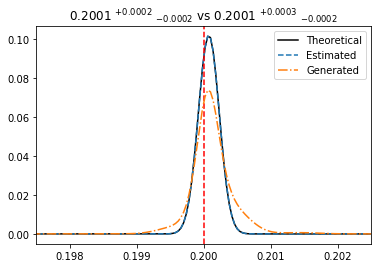

In [39]:
plt.plot(q_real, real_posterior, c='k', label='Theoretical')
plt.plot(q_posterior, posterior, linestyle='--', label='Estimated')
#plt.fill_between(q_posterior[id1:id2+1], posterior[id1:id2+1],  alpha=0.5, color='C0')
plt.axvline(q_fid, linestyle='--', color='r')
max_est = q_posterior[np.argmax(posterior)]
upp_bound = q_posterior[id2] - max_est
low_bound = max_est - q_posterior[id1]

# from the ML, with the corresponding error
# confidence levels of the generated one
sorted_posterior = sorted(likelihood_arr[:, 1], reverse=True)
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_bins
try:
    condition = np.where(likelihood_arr[:, 1] >= rep_level, 1, -1)
    id1_gen, id2_gen = np.argwhere(np.diff(condition)).flatten()
except:
    id1_gen, id2_gen = 0, 0
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
#plt.fill_between(likelihood_arr[id1_gen:id2_gen+1, 0], likelihood_arr[id1_gen:id2_gen+1, 1], alpha=0.5, color='C1')
max_est_gen = likelihood_arr[:, 0][np.argmax(likelihood_arr[:, 1])]
upp_bound_gen = likelihood_arr[:, 0][id2_gen] - max_est_gen
low_bound_gen = max_est_gen - likelihood_arr[:, 0][id1_gen]
plt.title(f'{max_est:.4f} $ ^{{ + {upp_bound:.4f} }}$ $ _{{ - {low_bound:.4f} }}$ vs {max_est_gen:.4f} $ ^{{ + {upp_bound_gen:.4f} }}$ $ _{{ - {low_bound_gen:.4f} }}$')
plt.legend()
plt.xlim([0.1975, 0.2025])

In [ ]:
q_fid

In [ ]:
plt.hist(posterior_samples, 100, histtype='step', density='True');